# Visualization and tumor segmentation with 3Dircadb1 dataset

### Download 3Dircadb1 dataset

In [ ]:
!wget -O 3Dircadb1.1.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.1
!wget -O 3Dircadb1.2.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.2
!wget -O 3Dircadb1.3.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.3
!wget -O 3Dircadb1.4.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.4
!wget -O 3Dircadb1.5.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.5
!wget -O 3Dircadb1.6.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.6
!wget -O 3Dircadb1.7.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.7
!wget -O 3Dircadb1.8.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.8
!wget -O 3Dircadb1.9.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.9
!wget -O 3Dircadb1.10.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.10
!wget -O 3Dircadb1.11.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.11
!wget -O 3Dircadb1.12.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.12
!wget -O 3Dircadb1.13.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.13
!wget -O 3Dircadb1.14.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.14
!wget -O 3Dircadb1.15.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.15
!wget -O 3Dircadb1.16.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.16
!wget -O 3Dircadb1.17.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.17
!wget -O 3Dircadb1.18.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.18
!wget -O 3Dircadb1.19.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.19
!wget -O 3Dircadb1.20.zip https://cloud.ircad.fr/index.php/s/JN3z7EynBiwYyjy/download?path=%2F3Dircadb1.20

### Import necessary libraries for handling DICOM files, image processing, file operations, data manipulation, and visualization.


In [2]:
# DICOM and File Handling
import pydicom as dicom
import zipfile
import os, shutil

# Image Processing and Numerical Operations
import cv2 
import numpy as np 
import copy
from math import *

# Data Manipulation and Visualization
import pandas as pd       
import matplotlib.pyplot as plt 
import imageio       
import ipywidgets as widgets   
import re                
from scipy import ndimage 

# SegmentAnything (SAM) for Tumor Segmentation
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor


%matplotlib inline

In [3]:
# Define the main directory where the ZIP files are located.
MAIN_DIR = '/content'

# Create a new directory to store the extracted contents of the ZIP files.
extracted_dir = "/content/3Dircadb1"
if not os.path.exists(extracted_dir):
    os.mkdir(extracted_dir)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/content/3Dircadb1'

***

### Extract and clean up directory

In [ ]:
# Iterate through each item in the main directory to extract ZIP files.
for folder in os.listdir(MAIN_DIR):
    # Check if the item is a ZIP file.
    if folder.endswith(".zip"):
        zip_path = os.path.join(MAIN_DIR, folder)
        # Open and extract the contents of the ZIP file into the designated directory.
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_dir)

# After extraction, remove the original ZIP files to clean up the main directory.
for folder in os.listdir(MAIN_DIR):
    if folder.endswith(".zip"):
        os.remove(os.path.join(MAIN_DIR, folder))

In [ ]:
# Update MAIN_DIR to point to the newly created directory containing the extracted files.
MAIN_DIR = extracted_dir

# Further decompress any nested ZIP files within each patient's folder.
for patient_folder in os.listdir(MAIN_DIR):
    patient_path = os.path.join(MAIN_DIR, patient_folder)
    # Iterate through each file in the patient's directory.
    for info_file in os.listdir(patient_path):
        # Check if the file is a ZIP archive.
        if info_file.endswith('.zip'):
            zip_file_path = os.path.join(patient_path, info_file)
            # Extract the ZIP file into the patient's directory.
            with zipfile.ZipFile(zip_file_path, "r") as zipObj:
                zipObj.extractall(patient_path)
            # Remove the ZIP file after extraction.
            os.remove(zip_file_path)

***

### Define hu-window for each organ and define utility functions

In [ ]:
# Define a dictionary containing windowing parameters for different organs.
# Each key is an organ, and the value is a tuple representing (window_width, window_length).
hu_window = dict()
hu_window['abdomen_soft'] = (400, 50)
hu_window['brain_bone'] = (2800, 600)
hu_window['brain_soft'] = (375, 40)
hu_window['liver'] = (150, 30)
hu_window['lungs'] = (1500, -600)
hu_window['mediastinum'] = (350, 50)
hu_window['spine_bone'] = (1800, 400)
hu_window['spine_soft'] = (250, 50)

In [ ]:
def sorted_alphanumeric(data):
    """
    Sorts a list in alphanumeric order.

    Parameters:
    data (list): The list of strings to sort.

    Returns:
    list: Alphanumerically sorted list.
    """
    # Define a lambda function to convert numeric strings to integers and lowercase other strings.
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    # Split each string into a list of strings and integers for proper sorting.
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    # Return the sorted list using the alphanum_key.
    return sorted(data, key=alphanum_key)

In [ ]:
def rm_file(file_path):
    """
    Deletes a file if it exists.

    Parameters:
    file_path (str): Path to the file to be deleted.
    """
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"File {file_path} removed successfully.")

In [ ]:
def get_img_scaling(patient_id):
    """
    Retrieves image scaling factors for a given patient.

    Parameters:
    patient_id (int): The ID of the patient.

    Returns:
    tuple: Contains number of slices in axial, coronal, sagittal planes and their respective scaling factors.
    """
    patient_data = patient_data_l[int(patient_id)]
    axial, coronal, sagittal = patient_data['img'].shape  # Dimensions of the image volume.
    axial_sp = patient_data['features']['SliceSpacing']  # Slice spacing in the axial plane.
    coronal_sp, sagittal_sp = patient_data['features']['sampling']  # Sampling rates for coronal and sagittal planes.
    
    # Calculate aspect ratios for different planes.
    axial_asp = coronal_sp / sagittal_sp
    sagittal_asp = axial_sp / coronal_sp
    coronal_asp = axial_sp / sagittal_sp
    
    return axial, coronal, sagittal, axial_asp, sagittal_asp, coronal_asp

In [ ]:
def window_image(patient_id, organ, w_width, w_length, rescale=True):
    """
    Applies windowing to the patient's image for a specific organ.

    Parameters:
    patient_id (int): The ID of the patient.
    organ (str): The organ to apply windowing to.
    w_width (int): Window width (range of Hounsfield Units).
    w_length (int): Window length (center of window).
    rescale (bool): Whether to rescale the image to 0-255.

    Returns:
    np.ndarray: The windowed image.
    """
    patient_data = patient_data_l[int(patient_id)]
    feature_dict = patient_data['features']
    img = copy.deepcopy(patient_data['img'])  # Deep copy to avoid modifying the original image.

    # Apply rescale slope and intercept from DICOM metadata for HU conversion.
    slope = feature_dict['RescaleSlope']
    intercept = feature_dict['RescaleIntercept']
    img = (img * slope + intercept)

    # Define the minimum and maximum HU levels based on windowing parameters.
    img_min = w_length - w_width / 2
    img_max = w_length + w_width / 2

    # Clamp the image intensities to the defined window range.
    img[img < img_min] = img_min
    img[img > img_max] = img_max

    # Rescale the image to a 0-255 range for visualization if required.
    if rescale:
        img = (img - img_min) / (img_max - img_min) * 255.0

    return img

***

### Load dataset into a list of dictionaries

In [ ]:
# Load dataset into a list of dictionaries, one for each patient.
num_patient = len(os.listdir(MAIN_DIR)) + 1  # Total number of patients (+1 for indexing starting at 1).
patient_data_l = [None] * num_patient       # Initialize the list with None.

# Iterate through each patient's folder in the main directory.
for patient_file in os.listdir(MAIN_DIR):
    # Extract the patient ID from the folder name. Assumes folder name format contains 'db1.{patient_id}'.
    _, patient_id = patient_file.split('db1.')
    patient_data = dict()  # Initialize a dictionary to store patient data.

    # Path to the directory containing the patient's DICOM images.
    img_dir = os.path.join(MAIN_DIR, patient_file, 'PATIENT_DICOM')
    
    # Store metadata features from the first image's metadata.
    patient_data['features'] = imageio.v2.imread(img_dir + '/image_0').meta

    # Read and sort all DICOM slices for the patient.
    slices = [dicom.dcmread(os.path.join(img_dir, s)) for s in sorted_alphanumeric(os.listdir(img_dir))]
    # Stack the pixel arrays from each slice to create a 3D image volume.
    patient_data['img'] = np.stack([s.pixel_array for s in slices])

    # Path to the directory containing the patient's mask DICOM files.
    mask_dirs = os.path.join(MAIN_DIR, patient_file, 'MASKS_DICOM')
    patient_data['mask'] = dict()  # Initialize a dictionary to store masks for different organs.

    # Iterate through each organ's mask folder.
    for mask_organ in os.listdir(mask_dirs):
        mask_folder = os.path.join(mask_dirs, mask_organ)
        # Read and sort all DICOM slices for the mask.
        mask_slices = [dicom.dcmread(os.path.join(mask_folder, s)) for s in sorted_alphanumeric(os.listdir(mask_folder))]
        # Stack the pixel arrays from each mask slice to create a 3D mask volume.
        patient_data['mask'][mask_organ] = np.stack([s.pixel_array for s in mask_slices])

    # Store the patient's data in the list using the patient ID as the index.
    patient_data_l[int(patient_id)] = patient_data

***

### Visualize

interactive(children=(IntSlider(value=64, description='axial_slice', max=128), IntSlider(value=255, descriptio…

<Figure size 640x480 with 0 Axes>

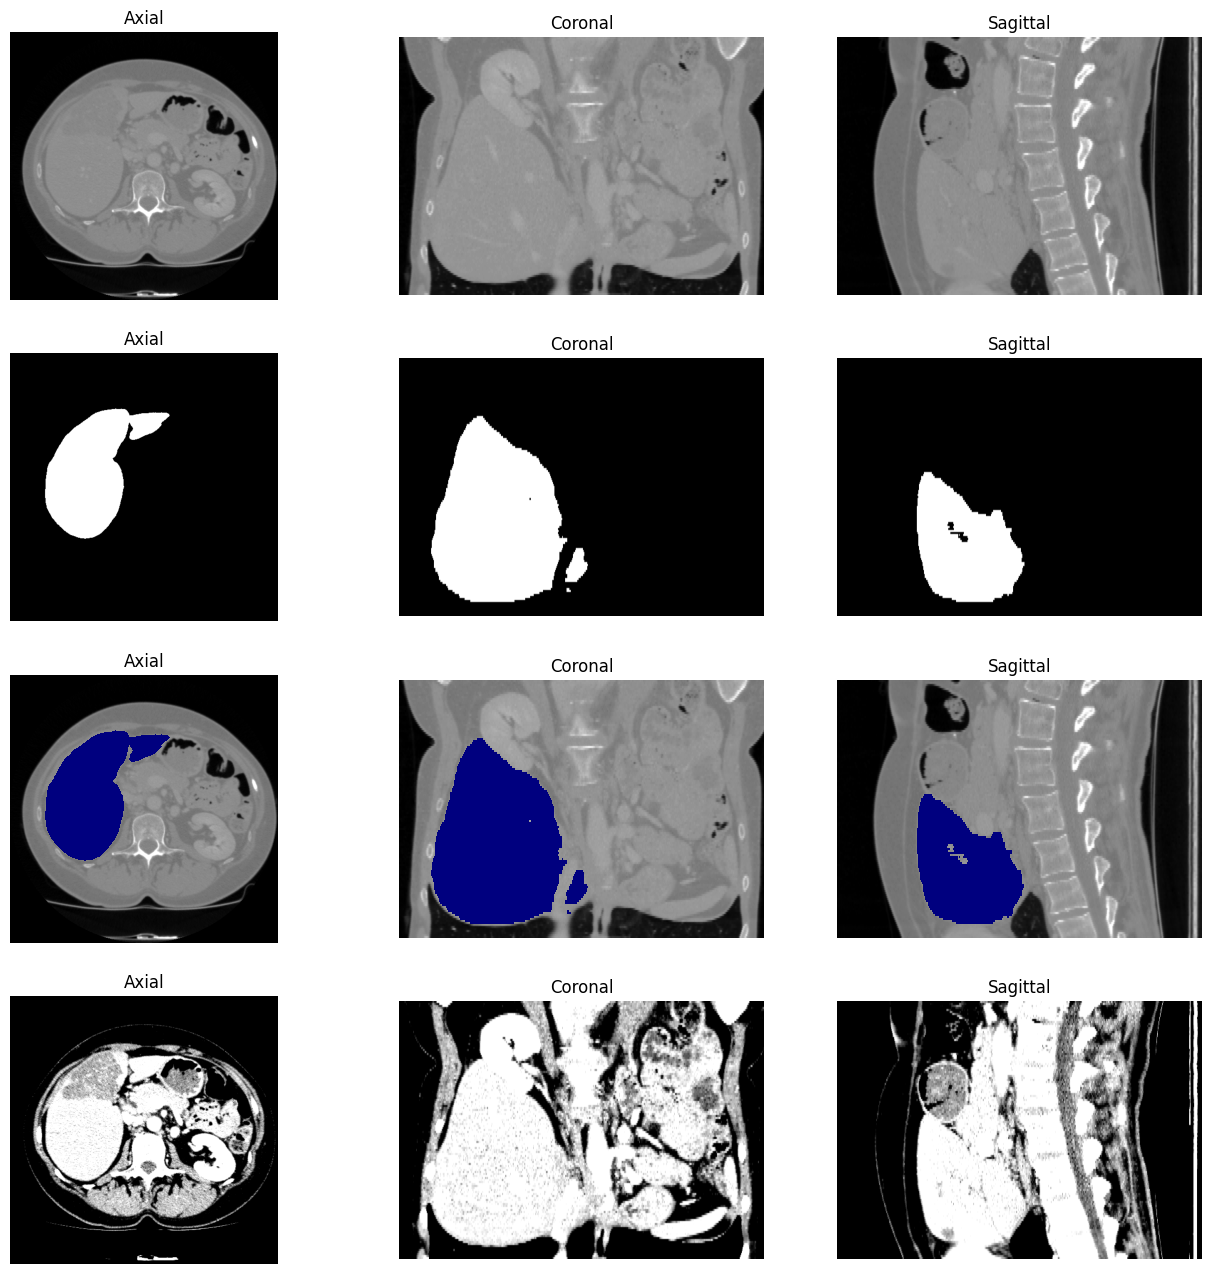

In [ ]:
# Initialize a matplotlib figure for DICOM slices visualization.
plt.figure(1)

def dicom_interact(patient_id, mask_organ):
    """
    Creates an interactive widget to visualize DICOM slices with masks for a specified patient and organ.

    Parameters:
    patient_id (int): The ID of the patient.
    mask_organ (str): The organ to visualize masks for.
    """
    # Retrieve image scaling factors.
    axial, coronal, sagittal, axial_asp, sagittal_asp, coronal_asp = get_img_scaling(patient_id)
    patient_data = patient_data_l[patient_id]
    img = patient_data['img']

    # Get windowing parameters for the specified organ. Default to 'liver' if not found.
    w_width, w_length = hu_window.get(mask_organ, hu_window['liver'])

    # Retrieve the mask for the specified organ and create a masked array.
    masked_img = patient_data['mask'][mask_organ]
    masked = np.ma.masked_where(masked_img == 0, masked_img)

    def dicom_animation(axial_slice, coronal_slice, sagittal_slice, window_width):
        """
        Updates the visualization based on selected slice indices and window width.

        Parameters:
        axial_slice (int): Index for the axial slice.
        coronal_slice (int): Index for the coronal slice.
        sagittal_slice (int): Index for the sagittal slice.
        window_width (int): Window width for HU windowing.
        """
        # Create a grid of subplots.
        fig, ax = plt.subplots(4, 3, figsize=(16, 16))

        # Apply windowing to the image.
        window_img = window_image(patient_id, mask_organ, window_width, w_length)

        # ---- Original Patient Slices ----
        # Display the axial slice.
        ax[0, 0].imshow(img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[0, 0].axis('off')
        ax[0, 0].set_title('Axial')

        # Display the coronal slice.
        ax[0, 1].imshow(img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[0, 1].axis('off')
        ax[0, 1].set_title('Coronal')

        # Display the sagittal slice.
        ax[0, 2].imshow(img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[0, 2].axis('off')
        ax[0, 2].set_title('Sagittal')

        # ---- Masked Organ Slices ----
        # Display the axial mask slice.
        ax[1, 0].imshow(masked_img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[1, 0].axis('off')
        ax[1, 0].set_title('Axial Mask')

        # Display the coronal mask slice.
        ax[1, 1].imshow(masked_img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[1, 1].axis('off')
        ax[1, 1].set_title('Coronal Mask')

        # Display the sagittal mask slice.
        ax[1, 2].imshow(masked_img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[1, 2].axis('off')
        ax[1, 2].set_title('Sagittal Mask')

        # ---- Overlayed Slices with Masks ----
        # Display the axial slice with mask overlay.
        ax[2, 0].imshow(img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[2, 0].imshow(masked[axial_slice, :, :], cmap='jet', aspect=axial_asp, interpolation='none', alpha=1)
        ax[2, 0].axis('off')
        ax[2, 0].set_title('Axial with Mask')

        # Display the coronal slice with mask overlay.
        ax[2, 1].imshow(img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[2, 1].imshow(masked[:, coronal_slice, :], cmap='jet', aspect=coronal_asp, interpolation='none', alpha=1)
        ax[2, 1].axis('off')
        ax[2, 1].set_title('Coronal with Mask')

        # Display the sagittal slice with mask overlay.
        ax[2, 2].imshow(img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[2, 2].imshow(masked[:, :, sagittal_slice], cmap='jet', aspect=sagittal_asp, interpolation='none', alpha=1)
        ax[2, 2].axis('off')
        ax[2, 2].set_title('Sagittal with Mask')

        # ---- Windowed Image Slices ----
        # Display the axial windowed image.
        ax[3, 0].imshow(window_img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[3, 0].axis('off')
        ax[3, 0].set_title('Axial Windowed')

        # Display the coronal windowed image.
        ax[3, 1].imshow(window_img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[3, 1].axis('off')
        ax[3, 1].set_title('Coronal Windowed')

        # Display the sagittal windowed image.
        ax[3, 2].imshow(window_img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[3, 2].axis('off')
        ax[3, 2].set_title('Sagittal Windowed')

        # Adjust layout for better spacing.
        plt.tight_layout()
        plt.show()

    # Create interactive widgets to control slice indices and window width.
    widgets.interact(
        dicom_animation,
        axial_slice=(0, axial - 1),           # Slider for axial slice selection.
        coronal_slice=(0, coronal - 1),       # Slider for coronal slice selection.
        sagittal_slice=(0, sagittal - 1),     # Slider for sagittal slice selection.
        window_width=(0, w_width * 2)         # Slider for window width adjustment.
    )

# Example usage: Visualize DICOM slices for patient with ID 1 and organ 'liver'.
dicom_interact(1, "liver")

***

### Examine metadata and count tumors

In [ ]:
# Initialize a list to store metadata for each patient.
metadata = [None] * (num_patient + 1)  # +1 to align patient IDs with list indices.

# Iterate through each patient's data to extract and compute metadata.
for pid, patient_data in enumerate(patient_data_l):
    if patient_data is not None:
        temp_data = dict()      # Temporary dictionary to store metadata for the current patient.
        cnt_tumor_pxl = 0       # Counter for the number of tumor pixels.
        cnt_liver_pxl = 0       # Counter for the number of liver pixels.
        cnt_tumor = 0           # Counter for the number of tumors.

        # Iterate through each organ's mask in the patient's data.
        for mask_organ in patient_data['mask'].keys():
            # Convert the mask to a binary image (1 for presence, 0 for absence).
            img = patient_data['mask'][mask_organ].astype(bool).astype(int)

            if mask_organ == 'liver':
                # Count the number of liver pixels.
                cnt_liver_pxl = np.sum(img)
                continue  # Skip further processing for the liver.

            if 'livertumor' in mask_organ:
                # Label connected components (tumors) in the mask.
                _, num_tumor = ndimage.label(img)
                # Accumulate the number of tumors.
                cnt_tumor += num_tumor
                # Accumulate the number of tumor pixels.
                cnt_tumor_pxl += np.sum(img)

        # Store the computed metadata for the patient.
        temp_data['tumor_size'] = cnt_tumor_pxl               # Total number of tumor pixels.
        temp_data['tumor_count'] = cnt_tumor                 # Total number of tumors.
        temp_data['liver_size'] = cnt_liver_pxl              # Total number of liver pixels.
        temp_data['tumor_scale'] = cnt_tumor_pxl / cnt_liver_pxl  # Ratio of tumor pixels to liver pixels.
        metadata[pid] = temp_data  # Assign the metadata to the corresponding patient index.


In [ ]:
# Display the tumor count and size for each patient.
for i in range(1, num_patient, 1):  # Iterate from patient ID 1 to num_patient - 1.
    print(f"Patient 1.{i}")
    print(f"Tumor count: {metadata[i]['tumor_count']}  Tumor size: {metadata[i]['tumor_size']} pixels   Tumor scale: {metadata[i]['tumor_scale']}\n")

Patient 1.1
Tumor count: 7  Tumor size: 214268 pixel   Tumor scale: 0.07478471315971241
Patient 1.2
Tumor count: 1  Tumor size: 14062 pixel   Tumor scale: 0.008532642728503953
Patient 1.3
Tumor count: 1  Tumor size: 14252 pixel   Tumor scale: 0.006000642504944046
Patient 1.4
Tumor count: 8  Tumor size: 6736 pixel   Tumor scale: 0.005948286291301779
Patient 1.5
Tumor count: 0  Tumor size: 0 pixel   Tumor scale: 0.0
Patient 1.6
Tumor count: 15  Tumor size: 434721 pixel   Tumor scale: 0.23774824404577977
Patient 1.7
Tumor count: 0  Tumor size: 0 pixel   Tumor scale: 0.0
Patient 1.8
Tumor count: 4  Tumor size: 20318 pixel   Tumor scale: 0.00631957425764131
Patient 1.9
Tumor count: 2  Tumor size: 39484 pixel   Tumor scale: 0.031202288568222408
Patient 1.10
Tumor count: 8  Tumor size: 14981 pixel   Tumor scale: 0.008003508914394884
Patient 1.11
Tumor count: 0  Tumor size: 0 pixel   Tumor scale: 0.0
Patient 1.12
Tumor count: 1  Tumor size: 348986 pixel   Tumor scale: 0.10444201634448454
Patie

### Initialize SAM (SegmentAnything) model

In [ ]:
# Define the SAM checkpoint and model type.
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# Define the computation device.
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the SAM model from the registry.
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)  # Move the model to the specified device.

# Initialize the SAM automatic mask generator.
mask_generator = SamAutomaticMaskGenerator(sam)

### Segmentation function using SAM

In [ ]:
def segment_tumor_with_sam(patient_id, slice_idx):
    """
    Segments tumors in a specific axial slice of a patient's image using SAM.

    Parameters:
    patient_id (int): The ID of the patient.
    slice_idx (int): The index of the axial slice to segment.

    Returns:
    list: A list of mask dictionaries generated by SAM.
    """
    # Retrieve the patient's image data.
    patient_data = patient_data_l[patient_id]
    img = patient_data['img'][slice_idx, :, :]  # Extract the specific axial slice.

    # Apply windowing for better visualization before segmentation.
    windowed_img = window_image(patient_id, 'liver', *hu_window.get('liver', (150, 30)))

    # Convert the windowed image to RGB as SAM expects 3-channel images.
    img_rgb = cv2.cvtColor(windowed_img, cv2.COLOR_GRAY2RGB)

    # Generate masks using SAM.
    masks = mask_generator.generate(img_rgb)

    return masks

### DICOM slices visualization with SAM Segmentation

In [ ]:
def show_anns(anns, ax=plt.gca()):
    """
    Visualizes segmentation masks on an axis.

    Parameters:
    anns (list): List of mask annotations.
    ax (matplotlib.axes.Axes): The axis to plot on.
    """
    if len(anns) == 0:
        return
    # Sort annotations by area in descending order.
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax.set_autoscale_on(False)

    # Initialize an RGBA image for mask visualization.
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0  # Set alpha channel to 0 (transparent).

    # Overlay each mask with a random color.
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])  # Random RGB and alpha.
        img[m] = color_mask
    ax.imshow(img)

def dicom_interact_with_sam(patient_id, mask_organ):
    """
    Creates an interactive widget to visualize DICOM slices with masks and SAM-generated tumor segments for a specified patient and organ.

    Parameters:
    patient_id (int): The ID of the patient.
    mask_organ (str): The organ to visualize masks for.
    """
    # Retrieve image scaling factors.
    axial, coronal, sagittal, axial_asp, sagittal_asp, coronal_asp = get_img_scaling(patient_id)
    patient_data = patient_data_l[patient_id]
    img = patient_data['img']

    # Get windowing parameters for the specified organ. Default to 'liver' if not found.
    w_width, w_length = hu_window.get(mask_organ, hu_window['liver'])

    # Retrieve the mask for the specified organ and create a masked array.
    if mask_organ in patient_data['mask']:
        masked_img = patient_data['mask'][mask_organ]
        masked = np.ma.masked_where(masked_img == 0, masked_img)
    else:
        print(f"No mask found for organ '{mask_organ}' in patient {patient_id}.")
        return

    def dicom_animation(axial_slice, coronal_slice, sagittal_slice, window_width):
        """
        Updates the visualization based on selected slice indices and window width.

        Parameters:
        axial_slice (int): Index for the axial slice.
        coronal_slice (int): Index for the coronal slice.
        sagittal_slice (int): Index for the sagittal slice.
        window_width (int): Window width for HU windowing.
        """
        # Clear previous plots.
        plt.clf()
        fig, ax = plt.subplots(4, 3, figsize=(20, 20))

        # Apply windowing to the image.
        window_img = window_image(patient_id, mask_organ, window_width, w_length)

        # ---- Original Patient Slices ----
        ax[0, 0].imshow(img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[0, 0].axis('off')
        ax[0, 0].set_title('Axial', fontsize=12)

        ax[0, 1].imshow(img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[0, 1].axis('off')
        ax[0, 1].set_title('Coronal', fontsize=12)

        ax[0, 2].imshow(img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[0, 2].axis('off')
        ax[0, 2].set_title('Sagittal', fontsize=12)

        # ---- Masked Organ Slices ----
        ax[1, 0].imshow(masked_img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[1, 0].axis('off')
        ax[1, 0].set_title('Axial Mask', fontsize=12)

        ax[1, 1].imshow(masked_img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[1, 1].axis('off')
        ax[1, 1].set_title('Coronal Mask', fontsize=12)

        ax[1, 2].imshow(masked_img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[1, 2].axis('off')
        ax[1, 2].set_title('Sagittal Mask', fontsize=12)

        # ---- Overlayed Slices with Masks ----
        # Overlay existing masks
        ax[2, 0].imshow(img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        ax[2, 0].imshow(masked[axial_slice, :, :], cmap='jet', aspect=axial_asp, interpolation='none', alpha=0.5)
        ax[2, 0].axis('off')
        ax[2, 0].set_title('Axial with Mask', fontsize=12)

        ax[2, 1].imshow(img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[2, 1].imshow(masked[:, coronal_slice, :], cmap='jet', aspect=coronal_asp, interpolation='none', alpha=0.5)
        ax[2, 1].axis('off')
        ax[2, 1].set_title('Coronal with Mask', fontsize=12)

        ax[2, 2].imshow(img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[2, 2].imshow(masked[:, :, sagittal_slice], cmap='jet', aspect=sagittal_asp, interpolation='none', alpha=0.5)
        ax[2, 2].axis('off')
        ax[2, 2].set_title('Sagittal with Mask', fontsize=12)

        # Perform SAM segmentation on the axial slice.
        sam_masks = segment_tumor_with_sam(patient_id, axial_slice)

        # Overlay SAM masks on the axial slice.
        ax[3, 0].imshow(window_img[axial_slice, :, :], cmap='gray', aspect=axial_asp)
        show_anns(sam_masks, ax[3, 0])
        ax[3, 0].axis('off')
        ax[3, 0].set_title('Axial SAM Segments', fontsize=12)

        # Optionally, repeat SAM segmentation for coronal and sagittal slices if desired.
        # For simplicity, only the axial slice is processed here.

        # Display the windowed coronal and sagittal slices.
        ax[3, 1].imshow(window_img[:, coronal_slice, :], cmap='gray', aspect=coronal_asp)
        ax[3, 1].axis('off')
        ax[3, 1].set_title('Coronal Windowed', fontsize=12)

        ax[3, 2].imshow(window_img[:, :, sagittal_slice], cmap='gray', aspect=sagittal_asp)
        ax[3, 2].axis('off')
        ax[3, 2].set_title('Sagittal Windowed', fontsize=12)

        # Adjust layout for better spacing.
        plt.tight_layout()
        plt.show()

    # Create interactive widgets to control slice indices and window width.
    widgets.interact(
        dicom_animation,
        axial_slice=(0, axial - 1),
        coronal_slice=(0, coronal - 1),
        sagittal_slice=(0, sagittal - 1),
        window_width=(0, w_width * 2)
    )

In [ ]:
# Example usage: Visualize DICOM slices for patient with ID 1 and organ 'liver'.
# You can change the patient_id and mask_organ as needed.
dicom_interact_with_sam(1, "liver")